In [1]:
%matplotlib inline

import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

logging.basicConfig(level=0)
logger = logging.getLogger(__name__)

In [2]:
with open("bp.csv", 'r') as bp_file:
    data = pd.read_csv(bp_file, sep=';')

x_peak = data[data.columns[0]].as_matrix()
y_peak = data[data.columns[1]].as_matrix()

In [3]:
# load file with positions and weights
with open("pos.txt", "r") as pos_file:
    pos_we_data = pd.read_csv(pos_file, sep=';')

positions = pos_we_data['position'].as_matrix()
weights = pos_we_data['weight'].as_matrix()

print("Positions: %s" % positions)
print("Weights: %s " % weights)

Positions: [ 12.  14.  18.  20.  24.  26.]
Weights: [ 0.1    0.05   0.125  0.225  0.15   0.35 ] 


In [4]:
class BraggPeak:
    def __init__(self, bp_domain, bp_vals):
        if len(bp_domain) != len(bp_vals):
            raise ValueError("Domain and vals have different lenghts!")
        self.tck = interpolate.splrep(bp_domain, bp_vals)
        self.initial_position = bp_domain[np.array(bp_vals).argmax()]
        self.current_position = self.initial_position
        self.weight = 1.0
        logger.debug("Creating BraggPeak...\nPrimary max position: %f\n"
                     "Calculated TCK (vector of knots, B-spline coefficients, degree of the spline):\n%s"
                     % (self.initial_position, self.tck))
        
    @property
    def position(self):
        return self.current_position
    
    @position.setter
    def position(self, new_position):
        self.current_position = new_position
        
    @property
    def weight(self):
        return self._weight
    
    @weight.setter
    def weight(self, new_weight):
        self._weight = new_weight
        
    def evaluate(self, x_arr):
        # todo: use ext=0 when moving peak to the right (we want some extrapolation)
        # use ext=1 (place zeros outside known domain) when moving peak left (we don't want negative values)
        return self._weight * interpolate.splev(x_arr + self.initial_position - self.current_position, self.tck, ext=3)


In [5]:
a = BraggPeak(x_peak, y_peak)

DEBUG:__main__:Creating BraggPeak...
Primary max position: 28.240000
Calculated TCK (vector of knots, B-spline coefficients, degree of the spline):
(array([  0.  ,   0.  ,   0.  , ...,  29.77,  29.77,  29.77]), array([ 0.19447   ,  0.19450826,  0.19454847, ...,  0.        ,
        0.        ,  0.        ]), 3)


In [6]:
a.weight = 2
a.position = 22.5

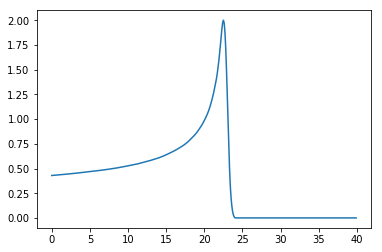

In [7]:
test_domain = np.arange(0, 40, .1)
kle = a.evaluate(test_domain)
plt.plot(test_domain, kle)

In [8]:
class SOBP:
    def __init__(self, peak_list):
        if not isinstance(peak_list, list) or not len(peak_list) > 0:
            raise TypeError("List object required!")
        for peak in peak_list:
            if not isinstance(peak, BraggPeak):
                raise TypeError("Peak list should consist of BraggPeak objects!")
        self.component_peaks = peak_list
    
    def overall_sum(self, domain):
        tmp_sobp = []
        for peak in self.component_peaks:
            tmp_peak = peak.evaluate(domain)
            tmp_sobp.append(tmp_peak)
        return sum(tmp_sobp)
        

In [9]:
s = SOBP([a, BraggPeak([1, 2, 3, 4, 5],[.1, .2, .5, 1, .2])])

DEBUG:__main__:Creating BraggPeak...
Primary max position: 4.000000
Calculated TCK (vector of knots, B-spline coefficients, degree of the spline):
(array([ 1.,  1.,  1.,  1.,  3.,  5.,  5.,  5.,  5.]), array([ 0.1       ,  0.18333333,  0.11666667,  1.58333333,  0.2       ,
        0.        ,  0.        ,  0.        ,  0.        ]), 3)


In [10]:
dom = np.arange(0, 30, .1)
so = s.overall_sum(dom)

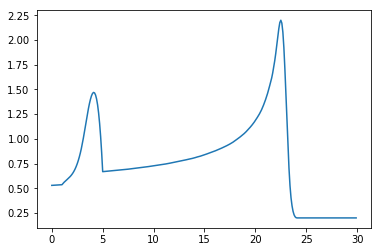

In [11]:
plt.plot(dom, so)

In [12]:
b = BraggPeak(x_peak, y_peak)
b.position = 18.
b.weight = .1

c = BraggPeak(x_peak, y_peak)
c.position = 19.5
c.weight = .15

d = BraggPeak(x_peak, y_peak)
d.position = 21.
d.weight = .20

e = BraggPeak(x_peak, y_peak)
e.position = 22.5
e.weight = .55

DEBUG:__main__:Creating BraggPeak...
Primary max position: 28.240000
Calculated TCK (vector of knots, B-spline coefficients, degree of the spline):
(array([  0.  ,   0.  ,   0.  , ...,  29.77,  29.77,  29.77]), array([ 0.19447   ,  0.19450826,  0.19454847, ...,  0.        ,
        0.        ,  0.        ]), 3)
DEBUG:__main__:Creating BraggPeak...
Primary max position: 28.240000
Calculated TCK (vector of knots, B-spline coefficients, degree of the spline):
(array([  0.  ,   0.  ,   0.  , ...,  29.77,  29.77,  29.77]), array([ 0.19447   ,  0.19450826,  0.19454847, ...,  0.        ,
        0.        ,  0.        ]), 3)
DEBUG:__main__:Creating BraggPeak...
Primary max position: 28.240000
Calculated TCK (vector of knots, B-spline coefficients, degree of the spline):
(array([  0.  ,   0.  ,   0.  , ...,  29.77,  29.77,  29.77]), array([ 0.19447   ,  0.19450826,  0.19454847, ...,  0.        ,
        0.        ,  0.        ]), 3)
DEBUG:__main__:Creating BraggPeak...
Primary max position: 28

In [13]:
inp_peaks = [b, c, d, e]
test_sobp = SOBP(inp_peaks)

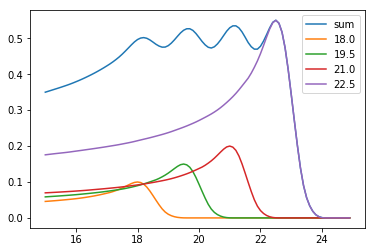

In [14]:
test_domain = np.arange(15, 25, 0.1)
plt.plot(test_domain, test_sobp.overall_sum(test_domain), label="sum")
for p in inp_peaks:
    plt.plot(test_domain, p.evaluate(test_domain), label=p.position)
plt.legend()